In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
--- Generating Synthetic Data (L_max = 3) ---
Generated 512000 data points.
--- Initializing Differentiable Inversion Model (L_max = 3) ---

--- Starting Optimization Loop ---
Epoch [200/3000], Loss: 0.1628, MSE: 0.1628, TempReg: 0.0000
Epoch [400/3000], Loss: 0.0167, MSE: 0.0166, TempReg: 0.0001
Epoch [600/3000], Loss: 0.0051, MSE: 0.0050, TempReg: 0.0001
Epoch [800/3000], Loss: 0.0019, MSE: 0.0018, TempReg: 0.0001
Epoch [1000/3000], Loss: 0.0009, MSE: 0.0008, TempReg: 0.0001
Epoch [1200/3000], Loss: 0.0006, MSE: 0.0005, TempReg: 0.0001
Epoch [1400/3000], Loss: 0.0005, MSE: 0.0003, TempReg: 0.0001
Epoch [1600/3000], Loss: 0.0004, MSE: 0.0003, TempReg: 0.0001
Epoch [1800/3000], Loss: 0.0004, MSE: 0.0002, TempReg: 0.0001
Epoch [2000/3000], Loss: 0.0003, MSE: 0.0002, TempReg: 0.0001
Epoch [2200/3000], Loss: 0.0003, MSE: 0.0002, TempReg: 0.0001
Epoch [2400/3000], Loss: 0.0003, MSE: 0.0002, TempReg: 0.0001
Epoch [2600/3000], Loss: 0.0003, MSE: 0.0002, TempReg: 0.0001
Epo

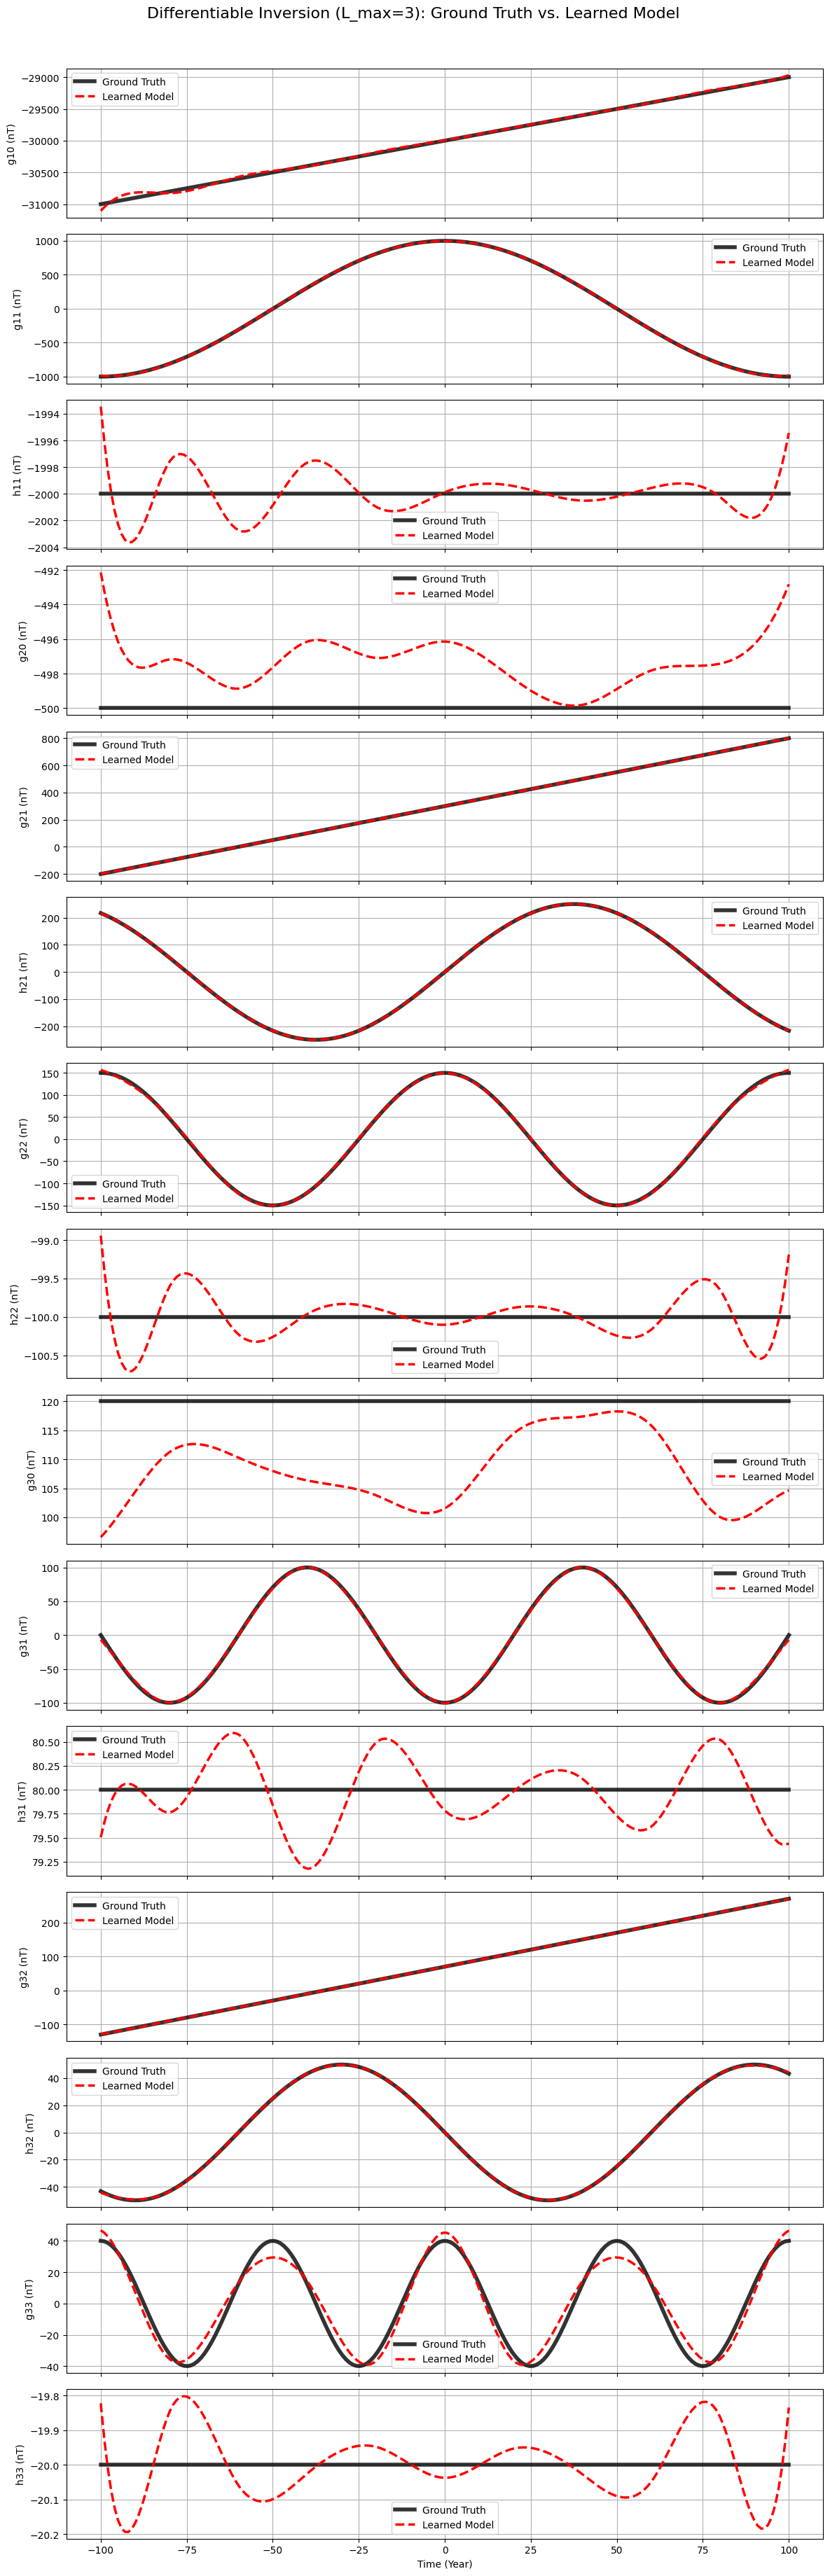

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

# =============================================================================
# 1. SETUP: Ground Truth and Synthetic Data Generation (with L=3)
# =============================================================================

def true_model_at_time(t: torch.Tensor, maxdegree: int) -> torch.Tensor:
    """Defines the ground truth Gauss coefficients as a function of time up to maxdegree."""
    # L=1 terms (Dipole)
    g10 = -30000.0 + 10.0 * t
    g11 = 1000.0 * torch.cos(2 * torch.pi * t / 200.0)
    h11 = -2000.0 * torch.ones_like(t)
    coeffs = [g10, g11, h11]
    
    if maxdegree >= 2:
        # L=2 terms (Quadrupole)
        g20 = -500.0 * torch.ones_like(t)
        g21 = 300.0 + 5.0 * t
        h21 = 250.0 * torch.sin(2 * torch.pi * t / 150.0)
        g22 = 150.0 * torch.cos(2 * torch.pi * t / 100.0)
        h22 = -100.0 * torch.ones_like(t)
        coeffs.extend([g20, g21, h21, g22, h22])

    if maxdegree >= 3:
        # L=3 terms (Octupole) - even weaker and with different variations
        g30 = 120.0 * torch.ones_like(t)
        g31 = -100.0 * torch.cos(2 * torch.pi * t / 80.0)
        h31 = 80.0 * torch.ones_like(t)
        g32 = 70.0 + 2.0 * t
        h32 = -50.0 * torch.sin(2 * torch.pi * t / 120.0)
        g33 = 40.0 * torch.cos(2 * torch.pi * t / 50.0)
        h33 = -20.0 * torch.ones_like(t)
        coeffs.extend([g30, g31, h31, g32, h32, g33, h33])
            
    # Pad with zeros for any higher degrees if necessary
    current_coeffs = len(coeffs)
    target_coeffs = (maxdegree + 1)**2 - 1
    for _ in range(target_coeffs - current_coeffs):
        coeffs.append(torch.zeros_like(t))
        
    return torch.stack(coeffs, dim=-1)

def generate_synthetic_data(n_times: int, n_locations: int, noise_level: float, maxdegree: int, device: str):
    """Generates noisy XYZ data from the true model."""
    print(f"--- Generating Synthetic Data (L_max = {maxdegree}) ---")
    times = torch.linspace(-100, 100, n_times, device=device)
    lats = torch.distributions.Uniform(-90.0, 90.0).sample((n_locations,)).to(device)
    lons = torch.distributions.Uniform(0.0, 360.0).sample((n_locations,)).to(device)
    t_grid, lat_grid, lon_grid = torch.meshgrid(times, lats, lons, indexing='ij')
    t_flat, lat_flat, lon_flat = t_grid.flatten(), lat_grid.flatten(), lon_grid.flatten()
    
    true_coeffs = true_model_at_time(t_flat, maxdegree)
    frechet_matrices = calculate_frechet_matrix(lat_flat, lon_flat, maxdegree)
    
    true_xyz = torch.bmm(frechet_matrices, true_coeffs.unsqueeze(-1)).squeeze(-1)
    noise = torch.randn_like(true_xyz) * noise_level
    observed_xyz = true_xyz + noise
    
    print(f"Generated {len(t_flat)} data points.")
    return t_flat, lat_flat, lon_flat, observed_xyz

# =============================================================================
# 2. DIFFERENTIABLE FORWARD MODEL 
# =============================================================================

def calculate_frechet_matrix(lat, lon, n_max):
    """
    Computes the Frechet matrix G using a validated algorithm adapted from
    the ChaosMagPy package by Clemens Kloss.
    
    """
    lat = torch.deg2rad(lat)
    lon = torch.deg2rad(lon)
    theta = np.pi/2 - lat  # colatitude
    
    num_coeffs = n_max * (n_max + 2)
    G = torch.zeros((len(theta), 3, num_coeffs), device=theta.device)

    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    sin_theta[sin_theta == 0] = 1e-8

    P = torch.zeros((n_max + 1, n_max + 1, len(theta)), device=theta.device)
    dP = torch.zeros((n_max + 1, n_max + 1, len(theta)), device=theta.device)
    P[0, 0, :] = 1.
    P[1, 1, :] = sin_theta

    root_n_n_1 = np.sqrt(np.arange(4, 2*n_max + 1, 2))
    root_n_n_1 = torch.from_numpy(root_n_n_1).to(theta.device)

    for n in range(2, n_max + 1):
        P[n, n, :] = root_n_n_1[n-2] * P[n-1, n-1, :] * sin_theta

    P[1, 0, :] = cos_theta
    for n in range(2, n_max + 1):
        P[n, n-1, :] = np.sqrt(2*n-1) * P[n, n, :] * cos_theta / sin_theta

    for n in range(2, n_max + 1):
        for m in range(n - 1):
            P[n, m, :] = ((2*n-1)*P[n-1, m, :]*cos_theta -
                          np.sqrt((n-1)**2-m**2)*P[n-2, m, :]) / np.sqrt(n**2-m**2)

    dP[0, 0, :] = 0.
    for n in range(1, n_max+1):
        for m in range(n+1):
            if n==m:
                dP[n, n, :] = np.sqrt(n/2)*P[n, n-1, :] + n*cos_theta/sin_theta * P[n, n, :]
            else:
                dP[n, m, :] = (np.sqrt(n**2-m**2)*P[n-1, m, :] -
                               n*cos_theta*P[n, m, :]) / sin_theta

    k = 0
    for n in range(1, n_max + 1):
        for m in range(n + 1):
            if m == 0:
                G[:, 0, k], G[:, 2, k] = dP[n, m, :], -n * P[n, m, :]
                k += 1
            else:
                cos_m_lon, sin_m_lon = torch.cos(m * lon), torch.sin(m * lon)
                G[:, 0, k] = dP[n, m, :]*cos_m_lon
                G[:, 1, k] = m*P[n, m, :]/sin_theta*sin_m_lon
                G[:, 2, k] = -n*P[n, m, :]*cos_m_lon
                k += 1
                G[:, 0, k] = dP[n, m, :]*sin_m_lon
                G[:, 1, k] = -m*P[n, m, :]/sin_theta*cos_m_lon
                G[:, 2, k] = -n*P[n, m, :]*sin_m_lon
                k += 1

    G[:, 0, :] *= -1
    G[:, 2, :] *= -1
    return G

# =============================================================================
# 3. THE INVERSION MODEL CLASS (using validated physics)
# =============================================================================

class DifferentiableInversion(nn.Module):
    def __init__(self, t_min, t_max, knot_step, maxdegree, spline_degree=3, device='cpu'):
        super().__init__()
        print(f"--- Initializing Differentiable Inversion Model (L_max = {maxdegree}) ---")
        
        self.maxdegree = maxdegree
        self.nr_coeffs = (maxdegree + 1)**2 - 1
        
        self.knots = np.arange(t_min - spline_degree * knot_step, 
                               t_max + (spline_degree + 1) * knot_step, 
                               knot_step)
        self.spline_degree = spline_degree
        self.nr_splines = len(self.knots) - self.spline_degree - 1
        
        # --- Pre-conditioning / Scaling Vector (EXTENDED to L=3) ---
        scaling = []
        if maxdegree >= 1:
            scaling.extend([30000.0, 2000.0, 2000.0])  # L=1
        if maxdegree >= 2:
            scaling.extend([600.0, 400.0, 400.0, 200.0, 200.0])  # L=2
        if maxdegree >= 3:
            # Octupole terms are weaker still
            scaling.extend([150.0, 120.0, 120.0, 80.0, 80.0, 50.0, 50.0]) # L=3
        self.coeff_scaling = torch.tensor(scaling, device=device)
        
        self.scaled_control_points = nn.Parameter(
            torch.randn(self.nr_splines, self.nr_coeffs) * 0.1 
        )
        self.B_matrix = None

    def build_bspline_basis(self, times: torch.Tensor):
        B_np = BSpline.design_matrix(times.cpu().numpy(), self.knots, self.spline_degree).toarray()
        self.B_matrix = torch.from_numpy(B_np).float().to(self.scaled_control_points.device)

    def get_coeffs_at_times(self, times: torch.Tensor) -> torch.Tensor:
        if self.B_matrix is None or self.B_matrix.shape[0] != len(times):
            self.build_bspline_basis(times)
        scaled_coeffs = self.B_matrix @ self.scaled_control_points
        physical_coeffs = scaled_coeffs * self.coeff_scaling
        return physical_coeffs

    def forward(self, t: torch.Tensor, lat: torch.Tensor, lon: torch.Tensor) -> torch.Tensor:
        coeffs_at_t = self.get_coeffs_at_times(t)
        frechet_matrices = calculate_frechet_matrix(lat, lon, self.maxdegree)
        predicted_xyz = torch.bmm(frechet_matrices, coeffs_at_t.unsqueeze(-1)).squeeze(-1)
        return predicted_xyz
        
# =============================================================================
# 4. TRAINING (OPTIMIZATION) LOOP
# =============================================================================

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
MAX_DEGREE = 3  # 
N_TIMES_DATA = 80
N_LOCS_DATA = 80 # Please increse N_LOCS_DATA if more L_max is added
NOISE_LEVEL = 3.0 # Reduced noise even further

# --- Hyperparameters ---
LEARNING_RATE = 5e-3      
NUM_EPOCHS = 3000 # More epochs for a more complex model      
L2_LAMBDA = 1e-7          
TEMP_LAMBDA = 1e-6        

# --- Prepare Data ---
t_obs, lat_obs, lon_obs, d_obs = generate_synthetic_data(
    N_TIMES_DATA, N_LOCS_DATA, NOISE_LEVEL, MAX_DEGREE, DEVICE
)

# --- Normalize the Data ---
data_mean = d_obs.mean(dim=0, keepdim=True)
data_std = d_obs.std(dim=0, keepdim=True)
d_obs_normalized = (d_obs - data_mean) / data_std

# --- Initialize Model and Optimizer ---
model = DifferentiableInversion(
    t_min=-100, t_max=100, knot_step=20, maxdegree=MAX_DEGREE, device=DEVICE
).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

print("\n--- Starting Optimization Loop ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    d_pred = model(t_obs, lat_obs, lon_obs)
    d_pred_normalized = (d_pred - data_mean) / data_std
    loss_mse = loss_fn(d_pred_normalized, d_obs_normalized)
    loss_l2 = L2_LAMBDA * torch.sum(model.scaled_control_points**2)
    diffs = model.scaled_control_points[1:] - model.scaled_control_points[:-1]
    loss_temporal = TEMP_LAMBDA * torch.sum(diffs**2)
    total_loss = loss_mse + loss_l2 + loss_temporal
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {total_loss.item():.4f}, "
              f"MSE: {loss_mse.item():.4f}, TempReg: {loss_temporal.item():.4f}")

# =============================================================================
# 5. PLOTTING AND EVALUATION
# =============================================================================
print("\n--- Plotting Final Results ---")
model.eval()
plot_times = torch.linspace(-100, 100, 200, device=DEVICE)
with torch.no_grad():
    learned_coeffs = model.get_coeffs_at_times(plot_times)
ground_truth_coeffs = true_model_at_time(plot_times, MAX_DEGREE)
learned_coeffs_np = learned_coeffs.cpu().numpy()
ground_truth_coeffs_np = ground_truth_coeffs.cpu().numpy()
plot_times_np = plot_times.cpu().numpy()

# Create labels for the plot
labels = []
for l in range(1, MAX_DEGREE + 1):
    labels.append(f'g{l}0')
    for m in range(1, l + 1):
        labels.extend([f'g{l}{m}', f'h{l}{m}'])

fig, axes = plt.subplots(model.nr_coeffs, 1, figsize=(12, 2.5 * model.nr_coeffs), sharex=True)
fig.suptitle(f"Differentiable Inversion (L_max={MAX_DEGREE}): Ground Truth vs. Learned Model", fontsize=16)
for i in range(model.nr_coeffs):
    ax = axes[i] if model.nr_coeffs > 1 else axes
    ax.plot(plot_times_np, ground_truth_coeffs_np[:, i], 'k-', label='Ground Truth', linewidth=4, alpha=0.8)
    ax.plot(plot_times_np, learned_coeffs_np[:, i], 'r--', label='Learned Model', linewidth=2.5)
    ax.set_ylabel(f'{labels[i]} (nT)')
    ax.legend()
    ax.grid(True)
axes[-1].set_xlabel('Time (Year)')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()